XGBoost for Flu Shot Learning
https://www.drivendata.org/competitions/66/flu-shot-learning/

In [40]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, roc_curve
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold

In [3]:
RND_SEED = 3

In [4]:
y = pd.read_csv('data/training_set_labels.csv',
                       index_col='respondent_id')
y_h1n1 = y['h1n1_vaccine']
y_seasonal = y['seasonal_vaccine']
X = pd.read_csv('data/training_set_features.csv',
                         index_col='respondent_id')

### Check for dtypes, missing values and statistical datatype 

In [5]:
X.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

#### Ordinal data:

In [6]:
X['age_group'].unique()

array(['55 - 64 Years', '35 - 44 Years', '18 - 34 Years', '65+ Years',
       '45 - 54 Years'], dtype=object)

In [7]:
X['education'].unique()

array(['< 12 Years', '12 Years', 'College Graduate', 'Some College', nan],
      dtype=object)

In [8]:
X['income_poverty'].unique()

array(['Below Poverty', '<= $75,000, Above Poverty', '> $75,000', nan],
      dtype=object)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RND_SEED, stratify=y_h1n1)

### Ordinal Encodings

In [10]:
age_group_transformer = OrdinalEncoder(categories=[['18 - 34 Years','35 - 44 Years','45 - 54 Years','55 - 64 Years', '65+ Years',]],
                            handle_unknown='use_encoded_value',
                            unknown_value=np.nan) #.fit_transform()

education_transformer = OrdinalEncoder(categories=[['< 12 Years', '12 Years', 'Some College', 'College Graduate']],
                            handle_unknown='use_encoded_value',
                            unknown_value=np.nan) #.fit_transform()

income_poverty_transformer = OrdinalEncoder(categories=[['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']],
                            handle_unknown='use_encoded_value',
                            unknown_value=np.nan) #.fit_transform()

In [11]:
# at_res = age_group_transformer.fit_transform(X_train['age_group'].values[:,np.newaxis])

In [12]:
#age_groups = X['age_group'].unique()
#age_groups.sort()
#ord_enc = OrdinalEncoder()
#ord_enc.fit(X[["age_group"]])
#X[["age_group"]] = ord_enc.transform(X[["age_group"]])

In [13]:
#ord_enc.categories_

In [14]:
#ord_enc_ed = OrdinalEncoder(categories=[['< 12 Years', '12 Years', 'Some College', 'College Graduate']],
#                            handle_unknown='use_encoded_value',
#                            unknown_value=np.nan)
#enc_ed = ord_enc_ed.fit_transform(X.loc[:,['education']], )

In [15]:
# assert that the nans are correctly treated
#np.testing.assert_array_equal(np.where(X['education'].isnull().values)[0],
#                              np.argwhere(np.isnan(enc_ed))[:,0])

In [16]:
#X[["education"]] = enc_ed

In [17]:
#X['income_poverty'].unique()

In [18]:
#ord_enc_ip = OrdinalEncoder(categories=[['Below Poverty', '<= $75,000, Above Poverty', '> $75,000']],
#                            handle_unknown='use_encoded_value',
#                            unknown_value=np.nan)
#ord_enc_ip = ord_enc_ip.fit_transform(X.loc[:,['income_poverty']], )
#X[["income_poverty"]] = ord_enc_ip

#### Categorial data

In [19]:
X['race'].unique()

array(['White', 'Black', 'Other or Multiple', 'Hispanic'], dtype=object)

In [20]:
X['sex'].unique()

array(['Female', 'Male'], dtype=object)

In [21]:
X['marital_status'].unique()

array(['Not Married', 'Married', nan], dtype=object)

In [22]:
X['rent_or_own'].unique()

array(['Own', 'Rent', nan], dtype=object)

In [23]:
X['employment_status'].unique()

array(['Not in Labor Force', 'Employed', 'Unemployed', nan], dtype=object)

In [24]:
X['hhs_geo_region'].unique()

array(['oxchjgsf', 'bhuqouqj', 'qufhixun', 'lrircsnp', 'atmpeygn',
       'lzgpxyit', 'fpwskwrf', 'mlyzmhmf', 'dqpwygqj', 'kbazzjca'],
      dtype=object)

In [25]:
X['census_msa'].unique()

array(['Non-MSA', 'MSA, Not Principle  City', 'MSA, Principle City'],
      dtype=object)

In [26]:
X['employment_industry'].unique()

array([nan, 'pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh',
       'ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf',
       'arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax',
       'dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo',
       'qnlwzans'], dtype=object)

In [27]:
X['employment_occupation'].unique()

array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [28]:
X.columns[X.dtypes == 'object']

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

### One Hot Encoding

In [29]:
#X = pd.get_dummies(X, columns=X.columns[X.dtypes == 'object'])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_features = X.columns[X.dtypes == 'object']



### Preprocessor

In [30]:
preprocessor = ColumnTransformer([
        ('ordinal_agegroup', age_group_transformer, ['age_group']),
        ('ordinal_education',education_transformer, ['education']),
        ('ordinal_income_poverty', income_poverty_transformer, ['income_poverty']),
        ('onehot', categorical_transformer, categorical_features)],
        remainder='passthrough' # keep unpreprocessed data
)


In [31]:
preprocessed_df = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out()).head()
preprocessed_df.head()

,ordinal_agegroup__age_group,ordinal_education__education,ordinal_income_poverty__income_poverty,onehot__age_group_18 - 34 Years,onehot__age_group_35 - 44 Years,onehot__age_group_45 - 54 Years,onehot__age_group_55 - 64 Years,onehot__age_group_65+ Years,onehot__education_12 Years,onehot__education_< 12 Years,...,remainder__health_worker,remainder__health_insurance,remainder__opinion_h1n1_vacc_effective,remainder__opinion_h1n1_risk,remainder__opinion_h1n1_sick_from_vacc,remainder__opinion_seas_vacc_effective,remainder__opinion_seas_risk,remainder__opinion_seas_sick_from_vacc,remainder__household_adults,remainder__household_children
0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,NaN,5.0,2.0,2.0,5.0,2.0,1.0,1.0,2.0
1,2.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,NaN,3.0,1.0,2.0,5.0,2.0,2.0,1.0,0.0
2,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,5.0,4.0,1.0,5.0,4.0,2.0,0.0,0.0
3,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,5.0,4.0,4.0,5.0,4.0,2.0,1.0,0.0
4,4.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,0.0,0.0


In [32]:
(preprocessed_df.dtypes != 'float64').any()

False

## Data Imbalance

In [33]:
np.sum(y)/len(y)

(20030, 2)

## Model

In [35]:
classifier = MultiOutputClassifier(xgb.XGBClassifier(objective='binary:logistic',
                            missing=1, seed=RND_SEED,
                           colsample_bytree=0.3,
                           max_depth=4,
                            gamma=0,
                           scale_pos_weight=25,))

clf = Pipeline([('preprocessor', preprocessor),
                ('classifier', classifier)])

clf.fit(X_train, y_train).fit(X_train,
            y_train,)

#classifier__early_stopping_rounds=10,
#            classifier__',
#            classifier__eval_set=[(X_test, y_test)]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_agegroup',
                                                  OrdinalEncoder(categories=[['18 '
                                                                              '- '
                                                                              '34 '
                                                                              'Years',
                                                                              '35 '
                                                                              '- '
                                                                              '44 '
                                                                              'Years',
                                                                              '45 '
                                                                              '- '
                                                                              '54 '
                                                                              'Years',
                                                                              '55 '
                                                                              '- '
                                                                              '64 '
                                                                              'Years',
                                                                              '65+ '
                                                                              'Years']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['age_group']),
                                                 ('ordinal_education',
                                                  OrdinalEncoder(categories=[['< '
                                                                              '1...
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=4,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=1,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...)))])

## Cross Validation

In [114]:
classifier_estimator_params = {
    'max_depth': [3,5,10],
     'n_estimators' :[75,100,125],
    'learning_rate' : [0.01, 0.1, 0.3,],
    'colsample_bytree': [0.75, 1],
    'subsample' : [0.6, 0.8, 1],
    #'alpha' : [0, 0.5, 1],
    #
    #    'gamma' : [25,],
    #
    #'scale_pos_weight' : [5,],
    #'min_child_weight' : [1.2,]
}
classifier_estimator_params = {'classifier__estimator__'+k : v for k,v in classifier_estimator_params.items()}


In [ ]:

param_grid = {**classifier_estimator_params}

CV = GridSearchCV(clf, 
                  param_grid, 
                  n_jobs= 1,
                 scoring='roc_auc',)

CV.fit(X_train, y_train)  
print(CV.best_params_)    
print(CV.best_score_)

In [102]:
y_pred = CV.best_estimator_.predict_proba(X_test)

In [103]:
y_pred_h1n1 = y_pred[0][ :, 1]
y_pred_seasonal = y_pred[1][ :, 1]

In [104]:
y_test_h1n1 = y_test.values[:,0]
y_test_seasonal = y_test.values[:,1]

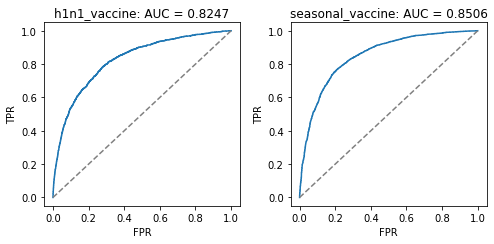

In [105]:
# see https://drivendata.co/blog/predict-flu-vaccine-data-benchmark/

def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'], 
    y_pred_h1n1, 
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'], 
    y_pred_seasonal, 
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()
